In [1]:
import argparse
import h5py
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [9]:
data = h5py.File('data/processed_train_dataset.hdf5', 'r')
labels = pd.read_csv('data/y_train_2.csv').values[:, 1]
print(data['conditions'].shape)

(261634, 11)


#### no slow oscillation in the next second

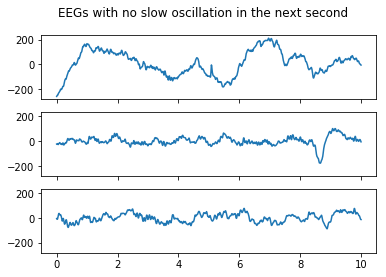

In [3]:
index = np.argwhere(labels == 0).reshape(-1)
x = np.linspace(0, 10, 1250)
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('EEGs with no slow oscillation in the next second')
axs[0].plot(x, data['mlp'][index[0]])
axs[1].plot(x, data['mlp'][index[1]])
axs[2].plot(x, data['mlp'][index[2]])
plt.savefig('data/no_slow.png')

#### slow oscillation of low amplitude

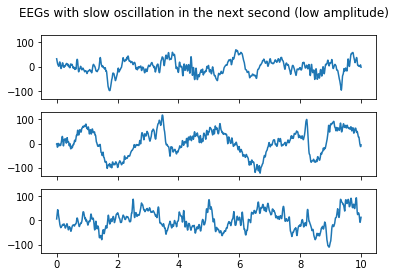

In [4]:
index = np.argwhere(labels == 1).reshape(-1)
x = np.linspace(0, 10, 1250)
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('EEGs with slow oscillation in the next second (low amplitude)')
axs[0].plot(x, data['mlp'][index[0]])
axs[1].plot(x, data['mlp'][index[1]])
axs[2].plot(x, data['mlp'][index[2]])
plt.savefig('data/low_slow.png')

#### slow oscillation of high amplitude

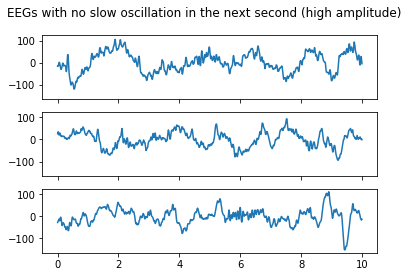

In [5]:
index = np.argwhere(labels == 2).reshape(-1)
x = np.linspace(0, 10, 1250)
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('EEGs with no slow oscillation in the next second (high amplitude)')
axs[0].plot(x, data['mlp'][index[0]])
axs[1].plot(x, data['mlp'][index[1]])
axs[2].plot(x, data['mlp'][index[2]])
plt.savefig('data/high_slow.png')

#### PCA data preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(data['mlp'])

# Apply transform to both the training set and the test set.
train_img = scaler.transform(data['mlp'])

In [7]:
train_img.shape

(261634, 1250)

In [8]:
from sklearn.decomposition import PCA

In [9]:
pca = PCA(.95)

In [10]:
pca.fit(train_img[:180000])

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [23]:
pca.n_components_

94

In [12]:
train_img = pca.transform(train_img)

In [14]:
test_data = h5py.File('data/processed_test_dataset.hdf5', 'r')

In [15]:
test_img = scaler.transform(test_data['mlp'])
test_img = pca.transform(test_img)

In [29]:
total = test_img.shape[0]
    
h5file = h5py.File('data/processed_test_dataset_pca.hdf5', "w")
d_mlp = h5file.create_dataset(
    "mlp", (total, pca.n_components_), dtype='f')
d_conditions = h5file.create_dataset(
    "conditions", (total, 11), dtype='f')

# Iterate and save all the questions and images.
for i in range(0, total, 10000):
    if i+10000 < total:
        d_mlp[i:i+10000] = test_img[i:i+10000, :]
        d_conditions[i:i+10000] = test_data['conditions'][i:i+10000]
    else:
        d_mlp[i:] = test_img[i:, :]
        d_conditions[i:] = test_data['conditions'][i:]
h5file.close()

#### PCA viz (not insightful)

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(train_img)

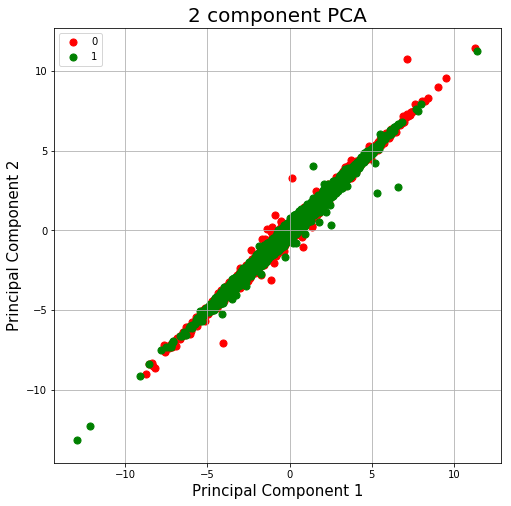

In [7]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [0,1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = np.argwhere(labels == target).reshape(-1)
    ax.scatter(train_img[indicesToKeep, 0]
               , train_img[indicesToKeep, 1]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()